In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [2]:
# First Step: Loading Datasets

data_df = spark.read.csv("clusteringAssets/Clustering.csv", header=True, inferSchema=True)

data_df.show(5)

+---------------+-----------------+--------------+-------------------+--------+--------------+---------------+
|Trash Pollution|Oil Concentration|Bacteria Level|Algae Concentration|Humidity|Wind Direction|Air Temperature|
+---------------+-----------------+--------------+-------------------+--------+--------------+---------------+
|            Low|             2.22|           207|               6.05|      52|           280|             38|
|           High|             1.37|           133|               4.21|      60|            30|           NULL|
|         Medium|             0.65|            84|               8.07|      18|           164|             12|
|           NULL|             2.62|           276|               6.53|      93|           254|             29|
|            Low|             1.68|           126|               1.73|      52|           176|             18|
+---------------+-----------------+--------------+-------------------+--------+--------------+---------------+
o

In [3]:
# Second Step: Select Features
data_df_features = data_df.select("Trash Pollution", "Oil Concentration", "Bacteria Level")

data_df_features.show(5)

+---------------+-----------------+--------------+
|Trash Pollution|Oil Concentration|Bacteria Level|
+---------------+-----------------+--------------+
|            Low|             2.22|           207|
|           High|             1.37|           133|
|         Medium|             0.65|            84|
|           NULL|             2.62|           276|
|            Low|             1.68|           126|
+---------------+-----------------+--------------+
only showing top 5 rows



In [4]:
# Third Step: Data Preprocessing -> Cleaning Data that contains NULL and Outliers
data_df_cleaned = data_df_features.dropna()

data_df_cleaned.show(5)

+---------------+-----------------+--------------+
|Trash Pollution|Oil Concentration|Bacteria Level|
+---------------+-----------------+--------------+
|            Low|             2.22|           207|
|           High|             1.37|           133|
|         Medium|             0.65|            84|
|            Low|             1.68|           126|
|           High|             1.03|           308|
+---------------+-----------------+--------------+
only showing top 5 rows



In [5]:
# Fourth Step: Data Transformation -> Transforming Categorical Data into Numerical Data
from pyspark.sql.functions import when

data_df_tranformation = data_df_cleaned.withColumn(
            "Trash Pollution", when(data_df_cleaned["Trash Pollution"] == "Low", 0).
                               when(data_df_cleaned["Trash Pollution"] == "Medium", 1).
                               otherwise(2))

data_df_tranformation.show(5)

+---------------+-----------------+--------------+
|Trash Pollution|Oil Concentration|Bacteria Level|
+---------------+-----------------+--------------+
|              0|             2.22|           207|
|              2|             1.37|           133|
|              1|             0.65|            84|
|              0|             1.68|           126|
|              2|             1.03|           308|
+---------------+-----------------+--------------+
only showing top 5 rows



In [6]:
# Fifth Step: Doing Normalization using StandardScaler and VectorAssembler
from pyspark.ml.feature import StandardScaler, VectorAssembler

data_df_tranformations = VectorAssembler(inputCols = data_df_tranformation.columns, outputCol = "Features").transform(data_df_tranformation)
scaler = StandardScaler(inputCol = "Features", outputCol = "features")
data_df_tranformations = scaler.fit(data_df_tranformations).transform(data_df_tranformations)

data_df_tranformations.show(5)

+---------------+-----------------+--------------+--------------------+
|Trash Pollution|Oil Concentration|Bacteria Level|            features|
+---------------+-----------------+--------------+--------------------+
|              0|             2.22|           207|[0.0,2.0954143327...|
|              2|             1.37|           133|[2.58653120876663...|
|              1|             0.65|            84|[1.29326560438331...|
|              0|             1.68|           126|[0.0,1.5857189545...|
|              2|             1.03|           308|[2.58653120876663...|
+---------------+-----------------+--------------+--------------------+
only showing top 5 rows



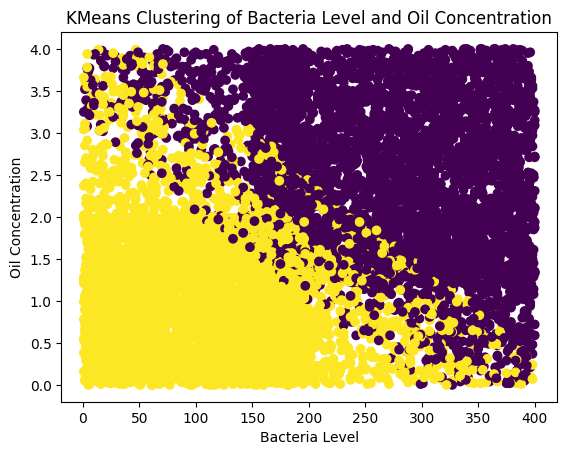

      Trash Pollution  Oil Concentration  Bacteria Level  \
0                   0               2.22             207   
1                   2               1.37             133   
2                   1               0.65              84   
3                   0               1.68             126   
4                   2               1.03             308   
...               ...                ...             ...   
9484                0               0.14              55   
9485                2               2.50             393   
9486                2               0.79             132   
9487                1               3.39              97   
9488                2               1.92              64   

                                               features  prediction  
0          [0.0, 2.095414332732459, 1.8847302908213417]           1  
1     [2.5865312087666315, 1.2931160521817424, 1.210...           1  
2     [1.2932656043833157, 0.6135222145387829, 0.764...           1  

In [8]:
# Sixth Step: Generating Models, in this case we will use KMeans
from pyspark.ml.clustering import KMeans
from matplotlib import pyplot as plt

model = KMeans().setK(2)
prediction = model.fit(data_df_tranformations).transform(data_df_tranformations)
pandas = prediction.toPandas()

# Plot the clusters
plt.scatter(pandas["Bacteria Level"], pandas["Oil Concentration"], c=pandas["prediction"])
plt.xlabel("Bacteria Level")
plt.ylabel("Oil Concentration")
plt.title("KMeans Clustering of Bacteria Level and Oil Concentration")
plt.show()

print(pandas)